In [1]:
!pip install beautifulsoup4
!pip install requests

In [2]:
import requests
from bs4 import BeautifulSoup
import re

### Load data on IMDb by BeautifulSoup

In [3]:
url = "https://250films.net/lists/imdb-top-250"
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')
titles = soup.find_all('a',{'class':"translated"})
process_title = []
count = 0
#print(titles)
# remove blank in titles
for i in titles:
    ii = i.get_text()
    process_title.append(ii)
    
#print(process_title)

In [4]:
url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"
html = requests.get(url)
soup = BeautifulSoup(html.text, 'html.parser')
links = soup.find_all("a", href = re.compile("^/title/tt\d"))
article = []
#link = links
for link in links[:200]:
    url = "https://www.imdb.com" + str(link['href']) + "plotsummary?ref_=tt_stry_pl#synopsis"
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    text = soup.find('li', id=re.compile('^synopsis-py'))
    # 'NoneType' object has no attribute 'get_text'
    if text is None: 
        pass
    else:
        article.append(text.get_text())
print(len(article))

194


In [5]:
import nltk,os
nltk.download('punkt')
doc_all = {}
i = 0
#print(article[0])
for title in process_title[:95]:
    tokens = nltk.word_tokenize(article[i])
    token_filtered = [w.lower() for w in tokens if w.isalpha()]
    doc_all[title]=token_filtered
    i += 1

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### convert all document to vector, use tfidf weighting

In [6]:
import numpy as np

def tf(term, token_doc):
    tf = token_doc.count(term)/len(token_doc)
    return tf

# create function to calculate how many doc contain the term 
def numDocsContaining(word, token_doclist):
    doccount = 0
    for doc_token in token_doclist:
        if doc_token.count(word) > 0:
            doccount +=1
    return doccount
  
import math
# create function to calculate  Inverse Document Frequency in doclist - this list of all documents
def idf(word, token_doclist):
    n = len(token_doclist)
    df = numDocsContaining(word, token_doclist)
    if df==0:
        return 0
    else:
        return math.log10(n/df)

#define a function to do cosine normalization a data dictionary
def cos_norm(dic): # dic is distionary data structure
    dic_norm={}
    factor=1.0/np.sqrt(sum([np.square(i) for i in dic.values()]))
    for k in dic:
        dic_norm[k] = dic[k]*factor
    return dic_norm

#create function to calculate normalize tfidf 
def compute_tfidf(token_doc,bag_words_idf):
    tfidf_doc={}
    for word in set(token_doc):
        if word not in bag_words_idf.keys(): # may not find keys
            pass
        else:
            tfidf_doc[word]= tf(word,token_doc) * bag_words_idf[word] 
    tfidf_norm = cos_norm(tfidf_doc)
    return tfidf_norm

# create normalize term frequency
def tf_norm(token_doc):
    tf_norm={}
    for term in token_doc:
        tf = token_doc.count(term)/len(token_doc)
        tf_norm[term]=tf
    tf_max = max(tf_norm.values())
    for term, value in tf_norm.items():
        tf_norm[term]= 0.5 + 0.5*value/tf_max
    return tf_norm

def compute_tfidf_query(query_token,bag_words_idf):
    tfidf_query={}
    tf_norm_query = tf_norm(query_token)
    for term, value in tf_norm_query.items():
        tfidf_query[term]=value*bag_words_idf[term]   
    return tfidf_query

In [7]:
import os
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start tfidf processing at", current_time)

#create bag words
bag_words =[] # declare bag_words is a list
for doc in doc_all.keys():
    bag_words += doc_all[doc]
bag_words=set(bag_words)

#calculate idf for every word in bag_words
bag_words_idf={}  
bag_words_len = len(bag_words)
bag_word_10 = round(bag_words_len/10,0)
print("the number of term in bag_word", bag_words_len)
print("Start idf processing")
i=0
for word in bag_words:
    i+=1
    if (i%bag_word_10==0):print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
    bag_words_idf[word]= idf(word,doc_all.values())

print("finish idf processing")
##calculate tfidf with cosine normalization
tfidf={} # declare tfidf dictionary to store tfidf value
for doc in doc_all.keys():
    tfidf[doc]= compute_tfidf(doc_all[doc],bag_words_idf)
    #print(tfidf[doc])
print("finish tfidf processing")

Start tfidf processing at 23:56:35
the number of term in bag_word 11403
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing
finish tfidf processing


### Input query text, and take similarity

In [8]:
query="encourage wise hope"
query_token_raw= nltk.word_tokenize(query)
query_token = [term for term in query_token_raw if term in bag_words]

tfidf_query =compute_tfidf_query(query_token,bag_words_idf) #calculate tfidf for query text
print(tfidf_query)

{'encourage': 1.3756636139608853, 'hope': 0.5627502573180297}


In [9]:
# add tfidf of query text to tfidf of all doc and convert to dataframe
tfidf["query"]=tfidf_query

import pandas as pd
tfidf_df = pd.DataFrame(tfidf).transpose()
tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero

from scipy.spatial.distance import cosine
cosine_sim ={}
for row in tfidf_df.index:
    if row != "query":
        cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Finish tfidf processing at", current_time)

{"Singin' in the Rain": 0.030520229710914726, 'Full Metal Jacket': 0.030520229710914726, 'Witness for the Prosecution': 0.008663323061407158, 'American Beauty': 0.008663323061407158, 'The Shawshank Redemption': 0.008284617989446463, 'The Godfather': 0.008284617989446463, 'Avengers: Infinity War': 0.006230191727395695, 'Rear Window': 0.006230191727395695, 'The Dark Knight Rises': 0.00573119481565898, 'Oldboy': 0.00573119481565898}
Finish tfidf processing at 23:57:35


In [10]:
#plot barchart
import matplotlib.pyplot as plt
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Course')

# save graph
path = r"C:\Users\USER\Desktop\Text-Mining\hw6"
plt.savefig(path+"barchart.png", bbox_inches='tight', dpi=600)
plt.show()

<Figure size 640x480 with 1 Axes>

### With feature selection process

In [11]:
from nltk.corpus import stopwords
stopword = nltk.download('stopwords')
tokens_no_stop = [word for word in bag_words if not word in stopwords.words()]
nltk.download('universal_tagset')
pos_tokens = nltk.pos_tag(tokens_no_stop, tagset='universal')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [12]:
def extract_terms(tokens):
    NVA_tokens =[] 
    for token in tokens:
        if token[1] == "NOUN":
            NVA_tokens += [token[0]]
        elif token[1] == "VERB":
            NVA_tokens += [token[0]]
        elif token[1] == "ADJ":
            NVA_tokens += [token[0]]
    return NVA_tokens

new_tokens = extract_terms(pos_tokens)

In [13]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
movies_porter = []
for words in new_tokens:
    movies_porter.append(ps.stem(words))
    
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")
nltk.download("maxent_treebank_pos_tagger")
nltk.download('averaged_perceptron_tagger')
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def lemmatize_sentence(words):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(words):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res

lem = WordNetLemmatizer()
lem_and_porter = lemmatize_sentence(movies_porter)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
print("Before extract:",len(pos_tokens))
print("After extract:",len(new_tokens))
print(len(lem_and_porter))

Before extract: 11180
After extract: 10420
10420


In [15]:
#calculate idf for every word in bag_words
new_tokens = set(new_tokens)
bag_words_idf={}  
bag_words_len = len(new_tokens)
bag_word_10 = round(bag_words_len/10,0)
print("the number of term after doing feature selection", bag_words_len)
print("Start idf processing")
i=0
for word in new_tokens:
    i+=1
    if (i%bag_word_10==0):print("finish %s idf processing" %(str(round(i*10/bag_word_10))+"%"))
    bag_words_idf[word]= idf(word,doc_all.values())

print("finish idf processing")
##calculate tfidf with cosine normalization
tfidf={} # declare tfidf dictionary to store tfidf value
for doc in doc_all.keys():
    tfidf[doc]= compute_tfidf(doc_all[doc],bag_words_idf)
    #print(tfidf[doc])
print("finish tfidf processing")

the number of term after doing feature selection 10420
Start idf processing
finish 10% idf processing
finish 20% idf processing
finish 30% idf processing
finish 40% idf processing
finish 50% idf processing
finish 60% idf processing
finish 70% idf processing
finish 80% idf processing
finish 90% idf processing
finish 100% idf processing
finish idf processing
finish tfidf processing


In [16]:
tfidf["query"] = tfidf_query
tfidf_df = pd.DataFrame(tfidf).transpose()
tfidf_df= tfidf_df.fillna(0) # replace all NaN by zero

cosine_sim ={}
for row in tfidf_df.index:
    if row != "query":
        cosine_sim[row]= 1-cosine(tfidf_df.loc[row],tfidf_df.loc["query"])

# the top 10 relevant document
cosine_sim_top10 = dict(sorted(cosine_sim.items(), key=lambda item: item[1],reverse=True)[:10])
print(cosine_sim_top10)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

print("\nFinish tfidf processing at", current_time)

{"Singin' in the Rain": 0.03072821588291219, 'Full Metal Jacket': 0.03072821588291219, 'Witness for the Prosecution': 0.008820116560966151, 'American Beauty': 0.008820116560966151, 'The Shawshank Redemption': 0.008315991910814002, 'The Godfather': 0.008315991910814002, 'Avengers: Infinity War': 0.006288661600306944, 'Rear Window': 0.006288661600306944, 'The Dark Knight Rises': 0.0058238621523377665, 'Oldboy': 0.0058238621523377665}

Finish tfidf processing at 00:00:10


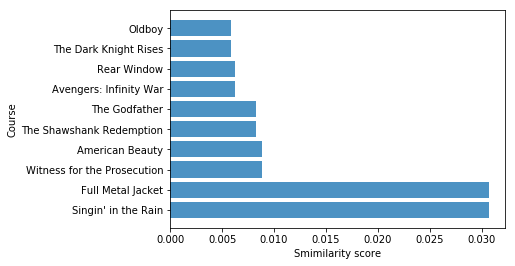

In [17]:
data = cosine_sim_top10
plt.barh(range(len(data)), list(data.values()), align='center', alpha=0.8)
plt.yticks(range(len(data)), list(data.keys())) # label for y axis
plt.xlabel('Smimilarity score')
plt.ylabel('Course')

# save graph
path = r"C:\Users\USER\Desktop\Text-Mining\hw6"
plt.savefig(path+"barchart_with_Feature_Selection.png", bbox_inches='tight', dpi=600)
plt.show()